# Evaluation for retrieval of images by tags

Based on several collections of images harvested from google images and tagged by clarifi.

In [1]:
import nbimporter
from benchmark import ImageTags
import numpy as np
from IPython.core.display import display, HTML, Image
import scipy.spatial.distance as dis

importing Jupyter notebook from benchmark.ipynb


In [2]:
I = ImageTags('inforet', 'googleimages', url='image_thumbnail_url', 
              selection=None)

In [3]:
def view(doc_id):
    display(HTML(I.html(doc_id)))

## Preview

In [ ]:
k = np.random.randint(0, I.M.shape[0])
view(k)
for t, p in sorted([(I.tags[x], round(I.probs[k][x], 3)) for x in np.where(I.probs[k] > 0)[0]],
                  key=lambda x: -x[1]):
    print t, p

## Retrieval

In [ ]:
query = ['outdoor', 'sport', 'outdoor', 'tennis', 'tennis']

### Vector space without weigth

In [ ]:
q1 = I.query_vector(query)
R1 = I.vector_search(q1, dis.cosine, use_tfidf=False)

In [ ]:
for img, sigma in R1[:10]:
    try:
        view(img)
        print sigma
    except ValueError:
        pass

### Vector space with weight

In [ ]:
q2 = I.query_vector(query, use_tfidf=True)
R2 = I.vector_search(q2, dis.cosine, use_tfidf=True)

In [ ]:
for img, sigma in R2[:10]:
    try:
        view(img)
        print sigma
    except ValueError:
        pass

### Multinomial search

In [ ]:
q3 = I.query_vector(query, use_tfidf=False)
R3 = I.multinomial_search(q3)

In [ ]:
for img, sigma in R3[:10]:
    try:
        view(img)
        print sigma
    except ValueError:
        pass

### Okapi BM25

In [ ]:
q4 = I.query_vector(query, use_tfidf=False)
R4 = I.bm25(q4)

In [ ]:
for img, sigma in R4[:10]:
    try:
        view(img)
        print sigma
    except ValueError:
        pass

## Generate queries for testing

In [ ]:
Q, D, T = I.generate_queries(n_queries=20, threshold=(5,0.85))

In [ ]:
for i, qdata in enumerate(Q):
    print 'topic', i
    print [x[0] for x in qdata[0]]
    for y in qdata[1]:
        try:
            view(I.docs.index(y[0]))
            print y[1]
        except ValueError:
            pass
    print ""
    break

# System evaluation

In [4]:
from sklearn import metrics

In [5]:
def norm(results, reverse=False):
    mn = min([x[1] for x in results])
    r_docs, r_weights = [], []
    for doc, rank in results:
        if mn < 0:
            rank += np.abs(mn)
        r_docs.append(doc)
        if reverse:
            r_weights.append(1-rank)
        else:
            r_weights.append(rank)
    r_weights = np.array(r_weights) / max(r_weights)
    return zip(r_docs, r_weights)

def prediction(results, threshold=0):
    r = norm(results)
    y_pred = np.zeros(len(I.docs))
    for doc, w in r:
        if w >= threshold:
            y_pred[doc] = 1
    return y_pred

In [6]:
Q, D, T = I.generate_queries(n_queries=20, threshold=(5,0.85))

In [29]:
query, thr = 12, 0.8

In [30]:
query_tags = [x[0] for x in Q[query][0]]
query_docs = [(I.docs.index(x), y) for x, y in Q[query][1]]

In [31]:
E = prediction(query_docs)

In [32]:
q1 = I.query_vector(query_tags)
R1 = norm(I.vector_search(q1, dis.cosine, use_tfidf=False), reverse=True)
q2 = I.query_vector(query_tags, use_tfidf=True)
R2 = norm(I.vector_search(q2, dis.cosine, use_tfidf=True), reverse=True)
q3 = I.query_vector(query_tags, use_tfidf=False)
R3 = norm(I.multinomial_search(q3))
q4 = I.query_vector(query_tags, use_tfidf=False)
R4 = norm(I.bm25(q4))

In [33]:
R1p = prediction(R1, threshold=thr)
R2p = prediction(R2, threshold=thr)
R3p = prediction(R3, threshold=thr)
R4p = prediction(R4, threshold=thr)

In [34]:
systems = [('Cosine', R1p), ('Cosine Weights', R2p), ('Multinomial', R3p), 
           ('BM25', R4p)]

In [35]:
rows = []
for s_name, r_res in systems:
    precision = metrics.precision_score(E, r_res)
    recall = metrics.recall_score(E, r_res)
    f1 = metrics.f1_score(E, r_res)
    rows.append("<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(s_name,
                                                                              round(precision, 2),
                                                                              round(recall, 2),
                                                                              round(f1, 2)))
table = "<table><tr><th>System</th><th>Precision</th><th>Recall</th><th>F1</th></tr>"
table += "{}</table>".format("\n".join(rows))
display(HTML(table))

System,Precision,Recall,F1
Cosine,0.4,0.63,0.49
Cosine Weights,0.39,0.44,0.41
Multinomial,0.42,0.63,0.5
BM25,0.33,0.56,0.42


## Precision-recall curve

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools

In [38]:
def score(results):
    scr = np.zeros(len(I.docs))
    for d, s in results:
        scr[d] = s
    return scr

In [39]:
scores = [('Cosine', score(R1)), ('Cosine Weights', score(R2)), 
          ('Multinomial', score(R3)), ('BM25', score(R4))]

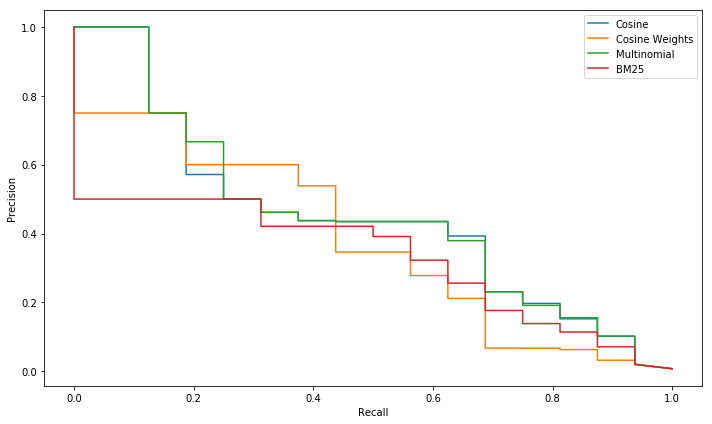

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
for sy, sc in scores:
    prec, rec, _ = metrics.precision_recall_curve(E, sc)
    i_prec = []
    for i, w in enumerate(prec):
        i_prec.append(max(prec[:i+1]))
    axes.plot(rec, i_prec, label=sy)
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

## ROC curve

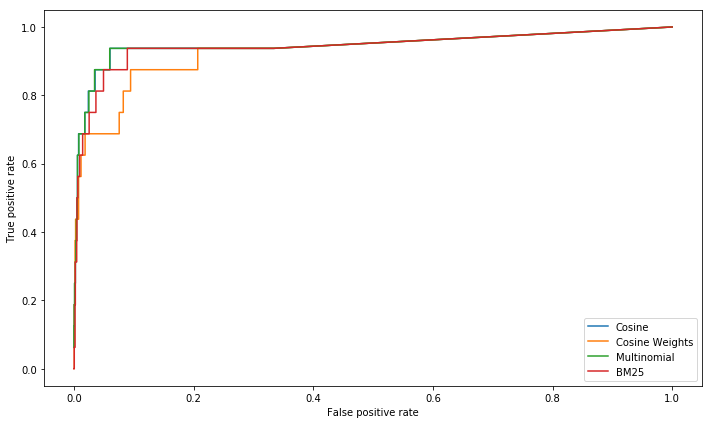

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
for sy, sc in scores:
    fpr, tpr, _ = metrics.roc_curve(E, sc)
    axes.plot(fpr, tpr, label=sy)
axes.set_xlabel('False positive rate')
axes.set_ylabel('True positive rate')
plt.legend()
plt.tight_layout()
plt.show()

## Confusion matrix

In [58]:
def cm_plot(ax, classes, CM, title, figure):
    im = ax.imshow(CM, interpolation='nearest', cmap=plt.cm.Blues)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    figure.colorbar(im, cax=cax, orientation='vertical')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=0, fontsize=16)
    ax.set_title(title, fontsize=16)
    thresh = CM.max() / 2.
    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        ax.text(j, i, CM[i, j], horizontalalignment="center",
                 color="white" if CM[i, j] > thresh else "black", fontsize=16)
    ax.set_ylabel('True label', fontsize=16)
    ax.set_xlabel('Predicted label', fontsize=16)

In [68]:
R1p = prediction(R1, threshold=thr)
R2p = prediction(R2, threshold=thr)
R3p = prediction(R3, threshold=thr)
R4p = prediction(R4, threshold=thr)
cm1 = metrics.confusion_matrix(E, R1p, labels=[1,0])
cm2 = metrics.confusion_matrix(E, R2p, labels=[1,0])
cm3 = metrics.confusion_matrix(E, R3p, labels=[1,0])
cm4 = metrics.confusion_matrix(E, R4p, labels=[1,0])

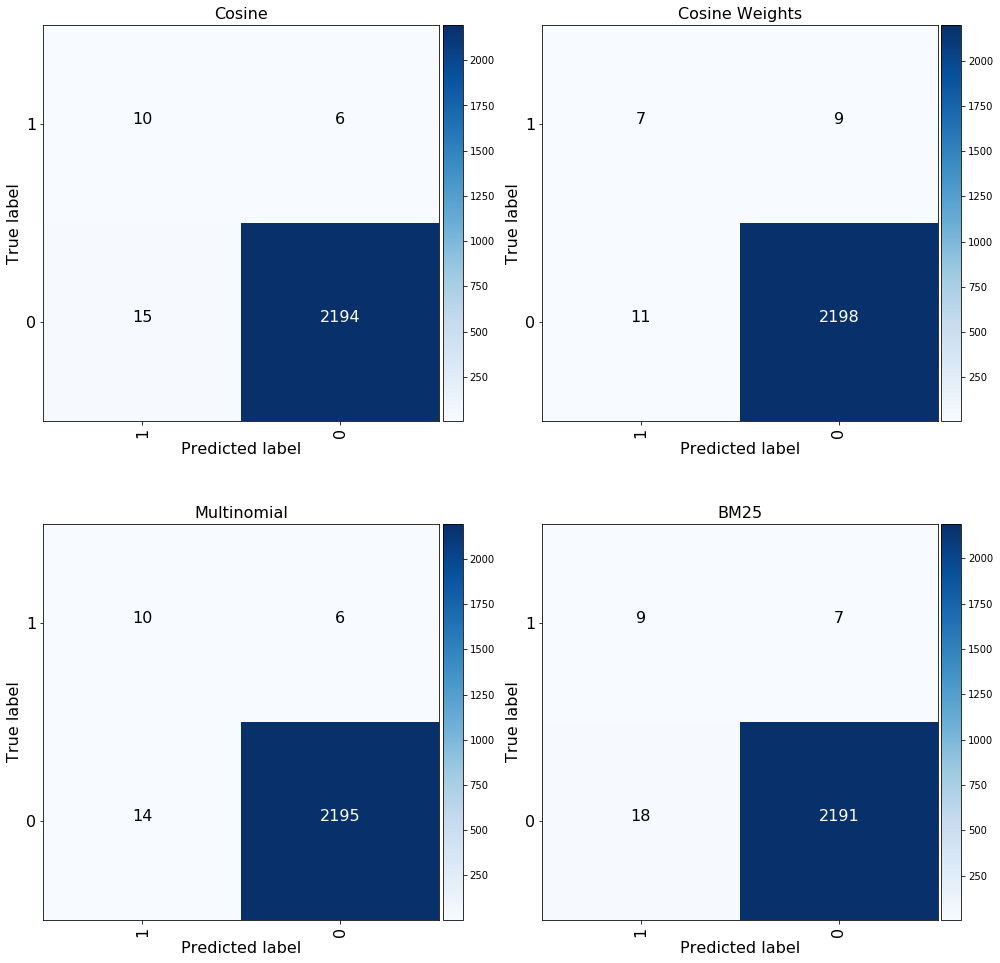

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
cm_plot(axes[0,0], [1,0], cm1, 'Cosine', fig)
cm_plot(axes[0,1], [1,0], cm2, 'Cosine Weights', fig)
cm_plot(axes[1,0], [1,0], cm3, 'Multinomial', fig)
cm_plot(axes[1,1], [1,0], cm4, 'BM25', fig)
plt.tight_layout()
plt.show()

# Queries by category
Use the spec function to build queries

In [71]:
C = ImageTags('inforet', 'googleimages', url='image_thumbnail_url', 
              selection={'category': 'sports'})
G = ImageTags('inforet', 'googleimages', url='image_thumbnail_url', 
              selection=None)

In [74]:
specs, sC, sG = {}, C.M.sum(), G.M.sum()

In [82]:
for i, tag in enumerate(C.tags):
    f, f_star = C.M[:,i].sum() / sC, G.M[:,G.tags.index(tag)].sum() / sG
    spec = (f - f_star)
    specs[tag] = spec

In [87]:
S = sorted(specs.items(), key=lambda x: -x[1])
print 'SPECIFIC'
for tag, tag_spec in S[:10]:
    print tag, tag_spec
print 'UNSPECIFIC'
for tag, tag_spec in S[-10:]:
    print tag, tag_spec

SPECIFIC
competition 0.0285651343351
ball 0.0269845210914
game 0.0222166164861
athlete 0.0207220971388
stadium 0.0178258435931
sports equipment 0.0168413384148
soccer 0.0162963422466
football 0.016180350578
match 0.0154736608168
sport 0.0129815451864
UNSPECIFIC
portrait -0.00501754190311
water -0.00606383343655
tourism -0.00619016585099
business -0.00636052264439
sky -0.00695911536952
architecture -0.00861002297178
city -0.00861940841145
fashion -0.00971505369582
woman -0.00974880471379
travel -0.0104346378581


In [124]:
query_tags = [x[0] for x in S if x[1] > 0.005]

In [125]:
E = prediction([(G.docs.index(x), 1.0) for x in C.docs])

In [126]:
q1 = G.query_vector(query_tags)
R1 = norm(G.vector_search(q1, dis.cosine, use_tfidf=False), reverse=True)
q2 = G.query_vector(query_tags, use_tfidf=True)
R2 = norm(G.vector_search(q2, dis.cosine, use_tfidf=True), reverse=True)
q3 = G.query_vector(query_tags, use_tfidf=False)
R3 = norm(G.multinomial_search(q3))
q4 = G.query_vector(query_tags, use_tfidf=False)
R4 = norm(I.bm25(q4))

In [127]:
R1p = prediction(R1, threshold=thr)
R2p = prediction(R2, threshold=thr)
R3p = prediction(R3, threshold=thr)
R4p = prediction(R4, threshold=thr)

In [128]:
systems = [('Cosine', R1p), ('Cosine Weights', R2p), ('Multinomial', R3p), 
           ('BM25', R4p)]

In [129]:
rows = []
for s_name, r_res in systems:
    precision = metrics.precision_score(E, r_res)
    recall = metrics.recall_score(E, r_res)
    f1 = metrics.f1_score(E, r_res)
    rows.append("<tr><td>{}</td><td>{}</td><td>{}</td><td>{}</td></tr>".format(s_name,
                                                                              round(precision, 2),
                                                                              round(recall, 2),
                                                                              round(f1, 2)))
table = "<table><tr><th>System</th><th>Precision</th><th>Recall</th><th>F1</th></tr>"
table += "{}</table>".format("\n".join(rows))
display(HTML(table))

System,Precision,Recall,F1
Cosine,1.0,0.19,0.32
Cosine Weights,1.0,0.06,0.11
Multinomial,1.0,0.19,0.32
BM25,1.0,0.21,0.34


In [130]:
scores = [('Cosine', score(R1)), ('Cosine Weights', score(R2)), 
          ('Multinomial', score(R3)), ('BM25', score(R4))]

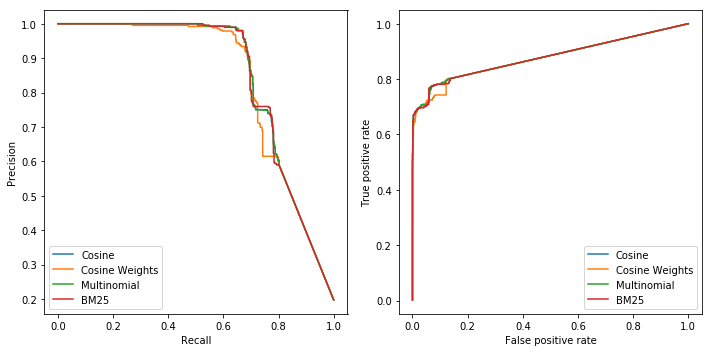

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for sy, sc in scores:
    prec, rec, _ = metrics.precision_recall_curve(E, sc)
    i_prec = []
    for i, w in enumerate(prec):
        i_prec.append(max(prec[:i+1]))
    axes[0].plot(rec, i_prec, label=sy)
    fpr, tpr, _ = metrics.roc_curve(E, sc)
    axes[1].plot(fpr, tpr, label=sy)
axes[1].set_xlabel('False positive rate')
axes[1].set_ylabel('True positive rate')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

In [132]:
R1p = prediction(R1, threshold=thr)
R2p = prediction(R2, threshold=thr)
R3p = prediction(R3, threshold=thr)
R4p = prediction(R4, threshold=thr)
cm1 = metrics.confusion_matrix(E, R1p, labels=[1,0])
cm2 = metrics.confusion_matrix(E, R2p, labels=[1,0])
cm3 = metrics.confusion_matrix(E, R3p, labels=[1,0])
cm4 = metrics.confusion_matrix(E, R4p, labels=[1,0])

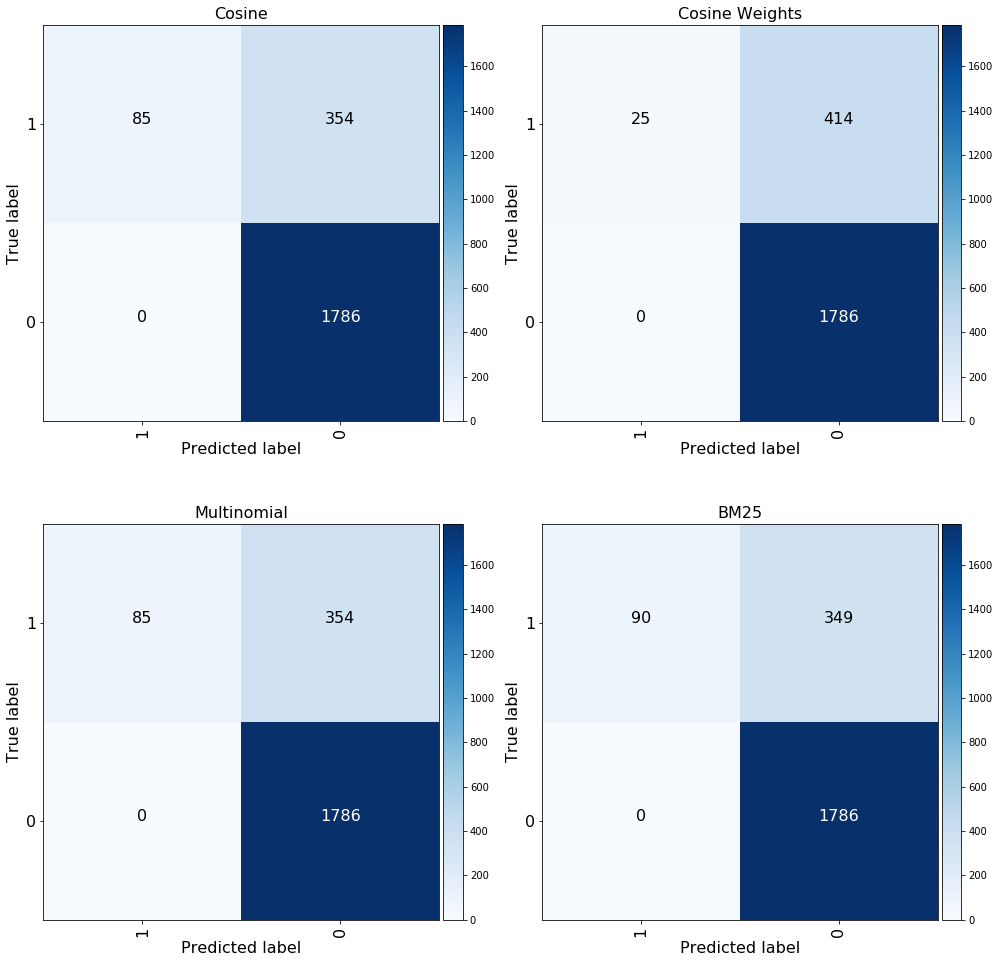

In [133]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
cm_plot(axes[0,0], [1,0], cm1, 'Cosine', fig)
cm_plot(axes[0,1], [1,0], cm2, 'Cosine Weights', fig)
cm_plot(axes[1,0], [1,0], cm3, 'Multinomial', fig)
cm_plot(axes[1,1], [1,0], cm4, 'BM25', fig)
plt.tight_layout()
plt.show()